In [1]:
import requests as rq
import datetime as dt
import pandas as pd
import os
import re
from matplotlib import pyplot as plt
import numpy as np
import plotly
import dash
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns
#--------------------------------- dash libraries --------------------------------------
import dash
import dash_table
import dash_bootstrap_components as dbc
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

## loading data

In [2]:
ita_url = 'http://raw.github.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni.csv'
ch_url = 'https://covid19.who.int/WHO-COVID-19-global-data.csv'



ita_raw = pd.read_csv(ita_url)
ch_raw = pd.read_csv(ch_url)

## DATA CLEANING FOR LOMBARDY

In [3]:
# select relvant data
print(ita_raw.columns)

ita_selected = pd.DataFrame({
    'date' : ita_raw[ita_raw['denominazione_regione'] == 'Lombardia']['data'],
    'new_cases_lom' : ita_raw[ita_raw['denominazione_regione'] == 'Lombardia']['nuovi_positivi'],
    'cum_deaths_lom' : ita_raw[ita_raw['denominazione_regione'] == 'Lombardia']['deceduti'],
    'cum_cases_lom' : ita_raw[ita_raw['denominazione_regione'] == 'Lombardia']['totale_casi']
    
    
})

print(ita_selected)

# turning time stamp inot pandas data format

ita_selected['date'] =[ pd.to_datetime(i.split("T")[0], format = "%Y-%m-%d" ) for i in ita_selected['date'] ]

Index(['data', 'stato', 'codice_regione', 'denominazione_regione', 'lat',
       'long', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')
                     date  new_cases_lom  cum_deaths_lom  cum_cases_lom
8     2020-02-24T18:00:00            166               6            172
29    2020-02-25T18:00:00             68               9            240
50    2020-02-26T18:00:00             18               9            258
71    2020-02-27T18:00:00            145              14            403
92    2020-02-28T18:00:00            128              17            531
...                   ...            ...             ...            ...
4817  2020-10-10T17:00:00           1140           16982  

## DATA CLEANING FOR SWITZERLAND

In [41]:
#select data

print(ch_raw.columns)

#ch_cumul=ch_raw[ ['date', 'ncumul_conf']# selected layer
ch_cumul=pd.DataFrame({
    
    'date' : ch_raw[ch_raw[' Country'] == 'Switzerland']['Date_reported'], 
    'new_cases_ch': ch_raw[ch_raw[' Country'] == 'Switzerland'][' New_cases'],
    'cum_deaths_ch' : ch_raw[ch_raw[' Country'] == 'Switzerland'][' Cumulative_deaths'],
    'cum_cases_ch' : ch_raw[ch_raw[' Country'] == 'Switzerland'][' Cumulative_cases'],
    
    })


# turn date as date object

new_dates=[ pd.to_datetime(i, format = "%Y-%m-%d" ) for  i in ch_cumul['date']]
ch_cumul[['date']]=list(new_dates)

ch_cumul.tail(5)

Index(['Date_reported', ' Country_code', ' Country', ' WHO_region',
       ' New_cases', ' Cumulative_cases', ' New_deaths', ' Cumulative_deaths'],
      dtype='object')


,date,new_cases_ch,cum_deaths_ch,cum_cases_ch
58911,2020-10-10,1485,1793,60230
58912,2020-10-11,0,1793,60230
58913,2020-10-12,0,1793,60230
58914,2020-10-13,4057,1800,64287
58915,2020-10-14,1439,1807,65726


## merging together layers form ch and lombardy

In [42]:
combined = ita_selected.merge(ch_cumul, on = 'date' ).set_index("date")
combined.head(5)

,new_cases_lom,cum_deaths_lom,cum_cases_lom,new_cases_ch,cum_deaths_ch,cum_cases_ch
date,,,,,,
2020-02-24,166,6,172,1,0,1
2020-02-25,68,9,240,2,0,3
2020-02-26,18,9,258,6,0,9
2020-02-27,145,14,403,5,0,14
2020-02-28,128,17,531,16,0,30


In [43]:
fig=go.Figure()
fig.add_trace(go.Scatter(x=combined.index, y=combined.new_cases_lom, name="lombardia"))
fig.add_trace(go.Scatter(x=combined.index, y=combined.new_cases_ch, name="svizzera"))

In [44]:
# smooth new cases by moving window 7 days
combined['new_ch_smooth'] = combined['new_cases_ch'].rolling(window=5).mean().fillna(0).astype(int)
combined['new_lom_smooth'] = combined['new_cases_lom'].rolling(window=5).mean().fillna(0).astype(int)
combined.tail()

,new_cases_lom,cum_deaths_lom,cum_cases_lom,new_cases_ch,cum_deaths_ch,cum_cases_ch,new_ch_smooth,new_lom_smooth
date,,,,,,,,
2020-10-10,1140,16982,111992,1485,1793,60230,1193,735
2020-10-11,1032,16985,113024,0,1793,60230,885,871
2020-10-12,696,16988,113720,0,1793,60230,745,906
2020-10-13,1080,16994,114800,4057,1800,64287,1342,986
2020-10-14,1844,17011,116644,1439,1807,65726,1396,1158


# plotting

<AxesSubplot:xlabel='date'>

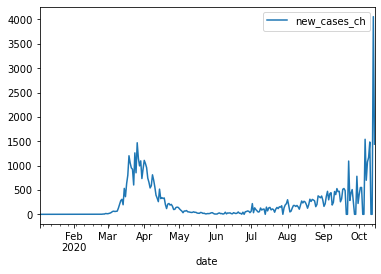

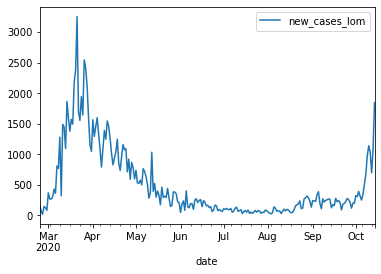

In [45]:
# plotting
ch_cumul.plot(x = "date", y = "new_cases_ch")

ita_selected.head(5)
ita_selected.plot(x = 'date', y = 'new_cases_lom')

## plot of new cases

In [46]:
m = 5
b = pd.to_datetime("2020-1-1").replace(month=m).month_name()
pd.to_datetime('today').month_name()

'October'

In [47]:
# plotting month by month
un_m = combined.index.month.unique()

pal_lom = sns.color_palette("Blues", n_colors=len(un_m)+2).as_hex()
pal_ch = sns.color_palette("Reds", n_colors=len(un_m)+2).as_hex()

In [48]:
m_traces=[]
c_c = 0 # color counter
for m in un_m:
    # data selection
    temp = combined[combined.index.month == m ]
    temp_lom = temp['new_lom_smooth']
    temp_ch = temp['new_ch_smooth']
    current_lom=temp['new_cases_lom']
    current_ch=temp['new_cases_ch']
    
    
    # prepare string and colour
    month_s = pd.to_datetime("2020-1-1").replace(month=int(m)).month_name()    
    col_lom = pal_lom[c_c]
    col_ch = pal_ch[c_c]
    m_s = 2
    m_o = 0.8 # marker opacity
    

    # create monthly traces
    if m == pd.to_datetime('today').month:
        # change viz param for current month
        m_o=1
        col_lom = pal_lom[c_c+1]
        col_ch = pal_ch[c_c+1]
        m_s = 3
        #remove for filled area
        """ note the traces have to be created one for each country otherwise they are assigned 
        to the wrong subplot"""
        area_lom1 = go.Scatter(x = temp_lom.index.day, 
                             y=temp_lom,
                             fill=None,
                             mode='lines',
                             line_color=col_lom,
                             showlegend=False
                            )
        area_ch1 = go.Scatter(x = temp_lom.index.day, 
                             y=temp_ch,
                             fill=None,
                             mode='lines',
                             line_color=col_ch,
                               showlegend=False
                            )
        area_lom2 = go.Scatter(x = temp_lom.index.day, 
                               y = current_lom,
                               fill='tonexty', # fill area between trace0 and trace1
                               mode='lines', 
                               line={'color' : col_lom, 'width': 1},
                               name= "Lombardia mese corrente",
                               hovertemplate="Lombardia: %{x}<br>nuovi casi : %{y:.1f}", 
                              
                              )
        area_ch2 = go.Scatter(x = temp_lom.index.day, 
                               y = current_ch,
                               fill='tonexty', # fill area between trace0 and trace1
                               mode='lines', 
                               line={'color' : col_ch, 'width': 1},
                               name= "Svizzera mese corrente",
                               hovertemplate="Svizzera: %{x}<br>nuovi casi : %{y:.1f}", 
                             )

        
        m_traces.extend([#th_m_lom,
                         #th_m_ch, 
                         area_lom1,area_ch1, area_lom2, area_ch2])
        
  
    m_lom=go.Scatter(x = temp_lom.index.day, 
                   y = temp_lom, 
                   name= f"{month_s}", 
                   marker_color=col_lom, 
                   line={'width': m_s},
                   opacity=m_o,
                   mode="lines",
                   hovertemplate=f"Lombardia: %{{x}} {month_s}<br>nuovi casi (media sett.): %{{y:.1f}}", 
                   showlegend=True
                    )
    m_ch=go.Scatter(x = temp_ch.index.day, 
                   y = temp_ch, 
                   name= f" {month_s}", 
                   marker_color=col_ch,
                   line={'width': m_s},
                   opacity=m_o,
                    text=month_s,
                   mode="lines",
                    hovertemplate=f"Svizzera: %{{x}} {month_s} <br>nuovi casi (media sett.): %{{y:.1f}}", 
                    showlegend=True
                   )
    m_traces.append(m_lom)
    m_traces.append(m_ch)
    c_c=c_c+1
# define which subplot
row_pos = tuple([1]*(len(m_traces)))   
col_pos = tuple([1,2]*(int(len(m_traces)/2)))
# add traces

fig1 =  make_subplots(rows=1, cols=2, 
                      subplot_titles=('Lombardia', 'Svizzera'), 
                      shared_yaxes =True
                     )
fig1.add_traces(m_traces, rows=row_pos, cols=col_pos)
#update layout
fig1.update_layout(plot_bgcolor="white", title="Nuovi casi (media settimanale) per mese")
fig1.update_yaxes(showgrid=True, gridwidth=0.2, gridcolor='lightgrey')
fig1.show()

## plot of deaths compared to new cases


<AxesSubplot:xlabel='date'>

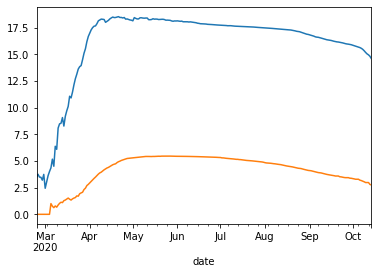

In [56]:
# data preparation
ratio= 100 
combined['deaths_ratio_lom']=ratio*combined.cum_deaths_lom/(combined.cum_cases_lom)
combined['deaths_ratio_lom'].plot()
combined['deaths_ratio_ch']= ratio*combined.cum_deaths_ch/(combined.cum_cases_ch) 
combined['deaths_ratio_ch'].plot()


In [78]:
fig2 =  make_subplots(rows=1, cols=1, 
                      shared_yaxes =True
                     )
fig2.add_trace(go.Scatter(x = combined.index, 
                          y = combined['cum_deaths_lom'], 
                          mode='markers',
                          name='Lombardia',
                          marker_size=[(4*a/max(combined['deaths_ratio_lom']))**2 for a in combined['deaths_ratio_lom']] ,
                         marker_color=[pal_lom[int(i)] for i in combined.index.month.values]
                         ))

fig2.add_trace(go.Scatter(x = combined.index, 
                          y = combined['cum_deaths_ch'], 
                          mode='markers', 
                          name="Svizzera",
                          marker_size=[(4*a/max(combined['deaths_ratio_ch']))**2 for a in combined['deaths_ratio_ch']] ,
                          marker_color=[pal_ch[int(i)] for i in combined.index.month.values]
                         ))

fig2.update_layout(plot_bgcolor="white", title="Morti cumulative")

      
fig2.update_yaxes(showgrid=True, gridwidth=0.2, gridcolor='lightgrey', title_text='numero di morti')
fig2.show()


In [ ]:
[a or 0 for a in combined.deaths_ratio_ch if np.isnan(a)]